
# Week 6 - Discovering Patterns: Clusters & Topics

This week, we seek to seek to discover patterns in our text data. First, we take a text corpus that we have developed and discovery emergent clusters through a process known as clustering or partitioning. We pilot this here both with a well-known *flat* clustering method, `kmeans`, and also a *hierarchical* approach, `Ward's (minimum variance) method`. We will demonstrate a simple (graphical) approach to identifying optimal cluster number, the sillhouette method, and evaluate the quality of unsupervised clusters on labeled data. Next, we will explore a method of two dimensional content clustering called topic modeling (e.g., words cluster in topics; topics cluster in documents). This statistical technique models and computationally induces *topics* from data, which are sparse distributions over (nonexclusive clusters of) words, from which documents can formally be described as sparse mixtures. We will explore these topics and consider their utility for understanding trends within a corpus. We will consider how to construct models that take document cluster and topic loadings as predictive features, the basis of influence metrics and dynamically over time.

For this notebook we will be using the following packages:

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json
import os

# Getting our corpora

To begin, we will use a well known corpus of testing documents from the *20 Newsgroups corpus*, a dataset commonly used to illustrate text applications of text clustering and classification. This comes packaged with sklearn and comprises approximately 20,000 newsgroup documents, partitioned (nearly) evenly across 20 newsgroups. It was originally collected by Ken Lang, probably for his 1995 *Newsweeder: Learning to filter netnews* paper. The data is organized into 20 distinct newsgroups, each corresponding to a different topic. Some of the newsgroups are very closely related (e.g. comp.sys.ibm.pc.hardware / comp.sys.mac.hardware), while others are unrelated (e.g misc.forsale / soc.religion.christian). 

In [ ]:
newsgroups = sklearn.datasets.fetch_20newsgroups(subset='train', data_home = '../data/scikit_learn_data')
print(dir(newsgroups))

We can ascertain the categories with `target_names` or the actual files with `filenames`

In [ ]:
print(newsgroups.target_names)
print(len(newsgroups.data))

We will start by converting the provided data into pandas DataFrames.

First we reduce our dataset for this analysis by dropping some extraneous information and converting it into a DataFrame.

In [ ]:
newsgroupsCategories = ['comp.sys.mac.hardware', 'comp.windows.x', 'misc.forsale', 'rec.autos']

newsgroupsDF = pandas.DataFrame(columns = ['text', 'category', 'source_file'])

for category in newsgroupsCategories:
    print("Fetching data for: {}".format(category))
    ng = sklearn.datasets.fetch_20newsgroups(subset='train', categories = [category], remove=['headers', 'footers', 'quotes'], data_home = '../data/scikit_learn_data/')
    newsgroupsDF = newsgroupsDF.append(pandas.DataFrame({'text' : ng.data, 'category' : [category] * len(ng.data), 'source_file' : ng.filenames}), ignore_index=True)

#Creating an explicit index column for later

#newsgroupsDF['index'] = range(len(newsgroupsDF))
#newsgroupsDF.set_index('index', inplace = True)
print(len(newsgroupsDF))
newsgroupsDF[:10]

Next, we can convert the documents into word count vectors (e.g., *soc.religion.christian message a* might contain 3 mentions of "church", 2 of "jesus", 1 of "religion", etc., yielding a CountVector=[3,2,1,...])

In [ ]:
#First it needs to be initialized
ngCountVectorizer = sklearn.feature_extraction.text.CountVectorizer()
#Then trained
newsgroupsVects = ngCountVectorizer.fit_transform(newsgroupsDF['text'])
print(newsgroupsVects.shape)

This gives us a matrix with row a document and each column a word. The matrix is mostly zeros, so we store it as a sparse matrix, a data structure that contains and indexes only the nonzero entries.

In [ ]:
newsgroupsVects

We can use the normal operations on this sparse matrix or convert it to normal matrix (not recommended for large sparse matrices :-)

In [ ]:
newsgroupsVects[:10,:20].toarray()

We can also lookup the indices of different words using the Vectorizer

In [ ]:
ngCountVectorizer.vocabulary_.get('vector')

There are some more interesting things to do...

Lets start with [term frequency–inverse document frequency](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html)(tf-idf), a method for weighting document-distinguishing words.

In [ ]:
#initialize
newsgroupsTFTransformer = sklearn.feature_extraction.text.TfidfTransformer().fit(newsgroupsVects)
#train
newsgroupsTF = newsgroupsTFTransformer.transform(newsgroupsVects)
print(newsgroupsTF.shape)

This gives us the tf-idf for each word in each text

In [ ]:
list(zip(ngCountVectorizer.vocabulary_.keys(), newsgroupsTF.data))[:20]

At first glance, there appears to be a lot of garbage littering this unordered list with unique words and stopwords. Note, however, that words like *apple*, *rgb*, and *voltage* distinguish this newsgroup document, while stopwords post a much lower weight. Note that we could filter out stop words, stem and lem our data before vectorizering, or we can instead use tf-idf to filter our data (or **both**). For exact explanation of all options look [here](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html). To prune this matrix of features, we now limit our word vector to 1000 words with at least 3 occurrences, which do not occur in more than half of the documents. There is an extensive science and art to feature engineering for machine learning applications like clustering.

In [ ]:
#initialize
ngTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
newsgroupsTFVects = ngTFVectorizer.fit_transform(newsgroupsDF['text'])

Lets look at the matrix

In [ ]:
newsgroupsDF['text']

The matrix is much smaller now, only 1000 words, but the same number of documents

We can still look at the words:

In [ ]:
try:
    print(ngTFVectorizer.vocabulary_['vector'])
except KeyError:
    print('vector is missing')
    print('The available words are: {} ...'.format(list(ngTFVectorizer.vocabulary_.keys())[:10]))

This is a reasonable matrix of features with which to begin identifying clusters.

# Flat Clustering with $K$-means

Lets start with $k$-means, an approach that begins with random clusters of predefined number, then iterates cluster reassignment and evaluates the new clusters relative to an objective function, recursively.

To do this we will need to know how many clusters we are looking for. Here the *true number* of clusters is 4. Of course, in most cases you would not know the number in advance.

In [ ]:
numClusters = len(set(newsgroupsDF['category']))
numClusters

Then we can initialize our cluster finder

In [ ]:
#k-means++ is a better way of finding the starting points
#We could also try providing our own
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')

And now we can calculate the clusters

In [ ]:
km.fit(newsgroupsTFVects)

Once we have the clusters, we can evaluate them with a variety of metrics that sklearn provides. We will look at a few, including *Homogeneity*, *Completeness*, *V-measure* and *Adjusted Rand Score*. 

*Homogeneity* is a measure that grows (from 0 to 1) to the degree that all of its clusters contain only data points which are members of a single class (e.g., newsgroup). 

*Completeness* is *Homogeneity's* converse: a measure that grows (0 to 1) to the degree that all data points of a given class are also elements of the same cluster.

The *V-measure* is the harmonic mean of *Homogeniety* and *Completeness* ($v = 2 * (homogeneity * completeness) / (homogeneity + completeness$).

the *Adjusted Rand Score* is built atop the *Rand Index (RI)*, which computes the similarity between two clusterings by considering all pairs of samples and counting pairs assigned in the same or different clusters in the predicted and true clusterings (e.g., actual newsgroups). The *RI* is then adjusted for chance as follows:
$ARI = (RI - RI_{expected}) / (max(RI) - RI_{expected})$.
The Adjusted Rand Index is thus ensured to have a value close to 0.0 for random labeling independent of the number of clusters and samples, 1.0 when the clusterings are identical, and -1.0 when they are as bad (i.e., cross-cutting) as they can be.

In [ ]:
print("The available metrics are: {}".format([s for s in dir(sklearn.metrics) if s[0] != '_']))
print("For our clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], km.labels_)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], km.labels_)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], km.labels_)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], km.labels_)))

You can evaluate these for different clustering solutions ($1-N$ clusters). You can also interrogate the alignment between specific documents and their cluster assignments by adding the cluster labels to the pandas dataframe.

In [ ]:
newsgroupsDF['kmeans_predictions'] = km.labels_
newsgroupsDF

We can also look at the distinguishing features in each cluster:

In [ ]:
terms = ngTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Let's construct a visualization of the clusters. First, we will first reduce the
dimensionality of the data using principal components analysis (PCA).

In [ ]:
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(newsgroupsTFVects.toarray())
reduced_data = pca.transform(newsgroupsTFVects.toarray())

The cell below is optional. It allows you to do a biplot

In [ ]:
components = pca.components_
keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
words = [terms[i] for i in keyword_ids]#Turn the ids into words.
x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
y = components[:,keyword_ids][1,:]

Then, let's build a color map for the true labels.

In [ ]:
colordict = {
'comp.sys.mac.hardware': 'red',
'comp.windows.x': 'orange',
'misc.forsale': 'green',
'rec.autos': 'blue',
    }
colors = [colordict[c] for c in newsgroupsDF['category']]
print("The categories' colors are:\n{}".format(colordict.items()))

Let's plot the data using the true labels as the colors of our data points.

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5, label = colors)
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

One nice thing about PCA is that we can also do a biplot and map our feature
vectors to the same space.

In [ ]:
fig = plt.figure(figsize = (16,9))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
ax.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.3, label = colors)
for i, word in enumerate(words):
    ax.annotate(word, (x[i],y[i]))
plt.xticks(())
plt.yticks(())
plt.title('True Classes')
plt.show()

Let's do it again with predicted clusters.

In [ ]:
colors_p = [colordict[newsgroupsCategories[l]] for l in km.labels_]

In [ ]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

Let's try with 3 clusters.

In [ ]:
km3 = sklearn.cluster.KMeans(n_clusters= 3, init='k-means++')
km3.fit(newsgroupsTFVects.toarray())

# Selecting Cluster Number

We can select an optimal cluster number by identifying the lowest of the metrics listed above (e.g., V-measure), but often you don't have "ground truth" or labeled data. For identifying the "best" number of clusters in an unsupervised way, we demonstrate the Silhouette method. Many other methods also exist (e.g., Bayesian Information Criteria or BIC, the visual "elbow criteria", etc.)

First we will define a helper function:

In [ ]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

Now we can examine a few different numbers of clusters:

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(3, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(4, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(5, X)

In [ ]:
X = newsgroupsTFVects.toarray()
plotSilhouette(6, X)

Interestingly, the silhouette scores above suggests that 3 is a better number of clusters than 4, which would be accurate if we (reasonsably) grouped the two computer-themed groups.

# Getting new text data

Lets start by using the same function as last lesson and loading a few press releases from 10 different senators into a DataFrame. The code to do this is below, but commented out as we've already downloaded the data to the data directory.

In [ ]:
targetSenator = 'Kennedy'# = ['Voinovich', 'Obama', 'Whitehouse', 'Snowe', 'Rockefeller', 'Murkowski', 'McCain', 'Kyl', 'Baucus', 'Frist']
"""
#Uncomment this to download your own data
senReleasesTraining = pandas.DataFrame()

print("Fetching {}'s data".format(targetSenator))
targetDF = lucem_illud.getGithubFiles('https://api.github.com/repos/lintool/GrimmerSenatePressReleases/contents/raw/{}'.format(targetSenator), maxFiles = 2000)
targetDF['targetSenator'] = targetSenator
senReleasesTraining = senReleasesTraining.append(targetDF, ignore_index = True)

#Watch out for weird lines when converting to csv
#one of them had to be removed from the Kennedy data so it could be re-read
senReleasesTraining.to_csv("data/senReleasesTraining.csv")
"""

senReleasesTraining = pandas.read_csv("../data/senReleasesTraining.csv")

senReleasesTraining[:5]

Now we have the files we can tokenize and normalize.

The normalized text is good, but we know that the texts will have a large amount of overlap so we can use tf-idf to remove some of the most frequent words. Before doing that, there is one empty cell, let's remove that.

In [ ]:
senReleasesTraining = senReleasesTraining.dropna(axis=0, how='any')

In [ ]:
#Similar parameters to before, but stricter max df and no max num occurrences
senTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=100, min_df=2, stop_words='english', norm='l2')
senTFVects = senTFVectorizer.fit_transform(senReleasesTraining['text'])
senTFVectorizer.vocabulary_.get('senat', 'Missing "Senate"')

# Clustering with our new data

One nice thing about using DataFrames for everything is that we can quickly convert code from one input to another. Below we are redoing the cluster detection with our senate data. If you setup your DataFrame the same way it should be able to run on this code, without much work.

First we will define what we will be working with

In [ ]:
targetDF = senReleasesTraining
textColumn = 'text'
numCategories = 3

Tf-IDf vectorizing

In [ ]:
exampleTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
exampleTFVects = ngTFVectorizer.fit_transform(targetDF[textColumn])

Running k means

In [ ]:
exampleKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
exampleKM.fit(exampleTFVects)

And visualize:

In [ ]:
examplePCA = sklearn.decomposition.PCA(n_components = 2).fit(exampleTFVects.toarray())
reducedPCA_data = examplePCA.transform(exampleTFVects.toarray())

colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in exampleKM.labels_]

In [ ]:
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_data[:, 0], reducedPCA_data[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

In this case, there may be two clusters that could be identified with Silhouette analysis or some of the metrics described above; although not having true classes makes that tricky. Below, we add these cluster assignments to the dataframe for individual perusal and evaluation.

In [ ]:
targetDF['kmeans_predictions'] = exampleKM.labels_
targetDF

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

### Loading data

In [2]:
def loadcorpus2(corpus_name, corpus_style="text"):
    texts_raw = {}
    for file in os.listdir(corpus_name + "/"):
        file2 = corpus_name + "/" + file
        print(file)
        texts_raw[file] = []
        with open(file2, encoding='utf-8') as f:
            for line in f:
                texts_raw[file].append(line)
    return texts_raw

In [3]:
speeches_dir = '../data/presidentialSpeechPeru/txt'
speeches_raw = loadcorpus2(speeches_dir)

mensaje-2001-at.txt
mensaje-2002-at.txt
mensaje-2003-at.txt
mensaje-2004-at.txt
mensaje-2005-at.txt
mensaje-2006-ag.txt
mensaje-2007-ag.txt
mensaje-2008-ag.txt
mensaje-2009-ag.txt
mensaje-2010-ag.txt
mensaje-2011-oh.txt
mensaje-2012-oh.txt
mensaje-2013-oh.txt
mensaje-2014-oh.txt
mensaje-2015-oh.txt
mensaje-2016-ppk.txt
mensaje-2017-ppk.txt
mensaje-2018-4.txt
mensaje-2019-01-vizcarra.txt
mensaje-1980-fbt.txt
mensaje-1981-fbt.txt
mensaje-1982-fbt.txt
mensaje-1983-fbt.txt
mensaje-1984-fbt.txt
mensaje-1985-ag.txt
mensaje-1986-ag.txt
mensaje-1987-ag.txt
mensaje-1988-ag.txt
mensaje-1989-ag.txt
mensaje-1990-af.txt
mensaje-1991-af.txt
mensaje-1992-af.txt
mensaje-1993-af.txt
mensaje-1994-af.txt
mensaje-1995-af.txt
mensaje-1996-af.txt
mensaje-1997-af.txt
mensaje-1998-af.txt
mensaje-1999-af.txt
mensaje-2000-af.txt


In [4]:
speech = pandas.DataFrame()

In [5]:
filenames = []
raw = []
for filename, raw_speech in speeches_raw.items():
    filenames.append(filename)
    raw.append(raw_speech)
speech['filename'] = filenames
speech['raw text'] = raw

In [6]:
import re

In [7]:
pattern = re.compile('[0-9]{4}')
speech['year'] = speech['filename'].apply(lambda x: pattern.search(x).group(0))
speech = speech.sort_values(by='year').reset_index(drop=True)

In [8]:
def clean_raw_text2(raw_texts):
    clean_texts = []
    for text in raw_texts:
        try:
            if type(text) == bytes:
                text = text.decode("utf-8")
            clean_text = text.replace(" \'m", "'m").replace(" \'ll", "'ll").replace(" \'re", "'re").replace(" \'s", "'s").replace(" \'re", "'re").replace(" n\'t", "n't").replace(" \'ve", "'ve").replace(" /'d", "'d")
            clean_text = clean_text.replace("\n", "").replace("\xa0", "").replace("\x0c", "")
            if not (clean_text == '' or clean_text == ' '):
                clean_texts.append(clean_text)
        except AttributeError:
            # print("ERROR CLEANING")
            # print(text)
            continue
        except UnicodeDecodeError:
            # print("Unicode Error, Skip")
            continue
    return ' '.join(clean_texts)

In [9]:
speech['cleaned text'] = speech['raw text'].apply(lambda x: clean_raw_text2(x))

In [10]:
speech.loc[(speech['year'].astype('int32') <= 1984), 'administration'] = 'Belaunde'

speech.loc[(speech['year'].astype('int32') >= 1985) & \
           (speech['year'].astype('int32') <= 1989), 'administration'] = 'Garcia (1)'

speech.loc[(speech['year'].astype('int32') >= 1990) & \
           (speech['year'].astype('int32') <= 2000), 'administration'] = 'Fujimori'

speech.loc[(speech['year'].astype('int32') >= 2001) & \
           (speech['year'].astype('int32') <= 2005), 'administration'] = 'Toledo'

speech.loc[(speech['year'].astype('int32') >= 2006) & \
           (speech['year'].astype('int32') <= 2010), 'administration'] = 'Garcia (2)'

speech.loc[(speech['year'].astype('int32') >= 2011) & \
           (speech['year'].astype('int32') <= 2015), 'administration'] = 'Humala'

speech.loc[(speech['year'].astype('int32') >= 2016), 'administration'] = 'Kuzcynski/Vizcarra'

In [11]:
speech.loc[(speech['year'].astype('int32') <= 1984), 'president'] = 'Belaunde'
speech.loc[(speech['year'].astype('int32') >= 1985) & \
           (speech['year'].astype('int32') <= 1989), 'president'] = 'Garcia'

speech.loc[(speech['year'].astype('int32') >= 1990) & \
           (speech['year'].astype('int32') <= 2000), 'president'] = 'Fujimori'

speech.loc[(speech['year'].astype('int32') >= 2001) & \
           (speech['year'].astype('int32') <= 2005), 'president'] = 'Toledo'

speech.loc[(speech['year'].astype('int32') >= 2006) & \
           (speech['year'].astype('int32') <= 2010), 'president'] = 'Garcia'

speech.loc[(speech['year'].astype('int32') >= 2011) & \
           (speech['year'].astype('int32') <= 2015), 'president'] = 'Humala'

speech.loc[(speech['year'].astype('int32') >= 2016) & \
           (speech['year'].astype('int32') <= 2017), 'president'] = 'Kuzcynski'

speech.loc[(speech['year'].astype('int32') >= 2018), 'president'] = 'Vizcarra'

In [12]:
speech['year-president'] = speech['year'] + '-' + speech['president']

### K-means

In [13]:
stop_words = ['de', 'y', 'la', 'el', 'en', 'que', 'a', 'los', 'del', 'para', 'las', 'con', 'se',
              'por', 'al', 'este', 'en', 'como', 'lo', 'el', 'la', 'las', 'los', 'su', 'sus', 'año', 'país']

In [14]:
speechTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(min_df=5, stop_words=stop_words, norm='l2')

In [15]:
targetDF = speech
textColumn = 'cleaned text'

In [16]:
speechTFVects = speechTFVectorizer.fit_transform(targetDF[textColumn])

In [17]:
terms = speechTFVectorizer.get_feature_names()

In [18]:
numCategories = 3
speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
speechKM.fit(speechTFVects)
targetDF['kmeans' + str(numCategories)] = speechKM.labels_

# Most representative words per cluster
#order_centroids = speechKM.cluster_centers_.argsort()[:, ::-1]
#components = speechPCA.components_
#keyword_ids = list(set(order_centroids[:,:10].flatten())) #Get the ids of the most distinguishing words(features) from your kmeans model.
#words = [terms[i] for i in keyword_ids]#Turn the ids into words.
#x = components[:,keyword_ids][0,:] #Find the coordinates of those words in your biplot.
#y = components[:,keyword_ids][1,:]

In [19]:
numCategories = 4
speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
speechKM.fit(speechTFVects)
targetDF['kmeans' + str(numCategories)] = speechKM.labels_

In [20]:
numCategories = 5
speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
speechKM.fit(speechTFVects)
targetDF['kmeans' + str(numCategories)] = speechKM.labels_

In [21]:
numCategories = 6
speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
speechKM.fit(speechTFVects)
targetDF['kmeans' + str(numCategories)] = speechKM.labels_

In [22]:
numCategories = 7
speechKM = sklearn.cluster.KMeans(n_clusters = numCategories, init='k-means++')
speechKM.fit(speechTFVects)
targetDF['kmeans' + str(numCategories)] = speechKM.labels_

### PCA

In [23]:
speechPCA = sklearn.decomposition.PCA(n_components = 2).fit(speechTFVects.toarray())
reducedPCA_speechData = speechPCA.transform(speechTFVects.toarray())

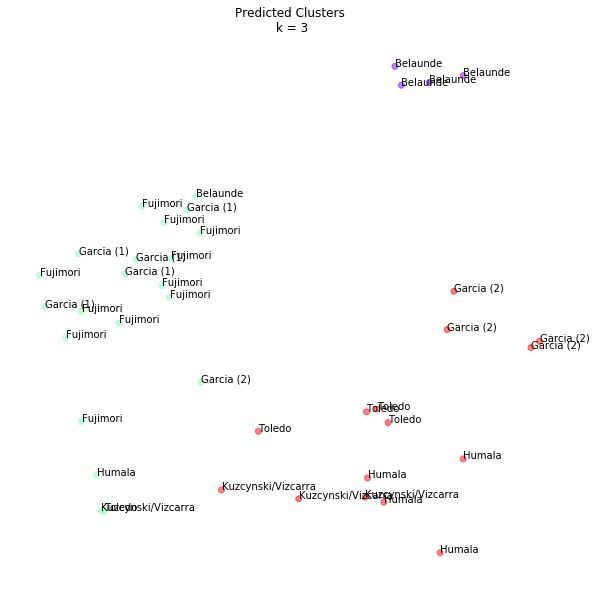

In [24]:
numCategories = 3
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
#for i, word in enumerate(words):
#    ax.annotate(word, (x[i],y[i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

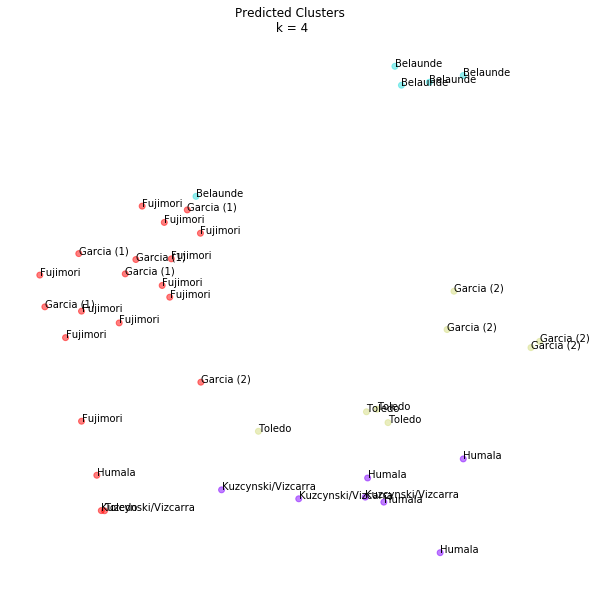

In [25]:
numCategories = 4
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

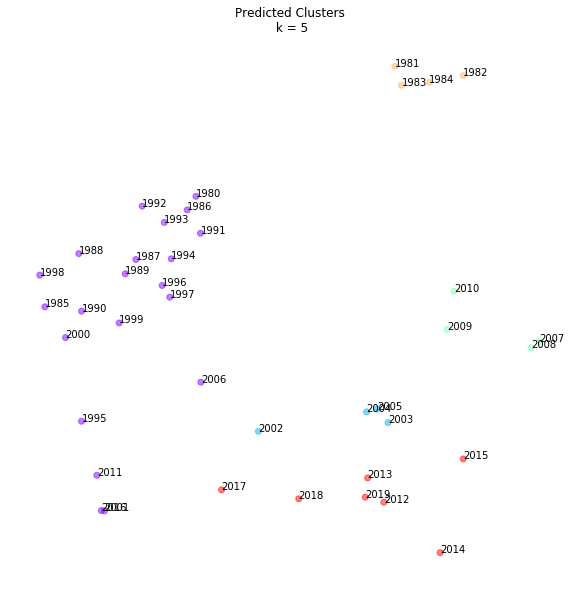

In [26]:
numCategories = 5
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]))
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

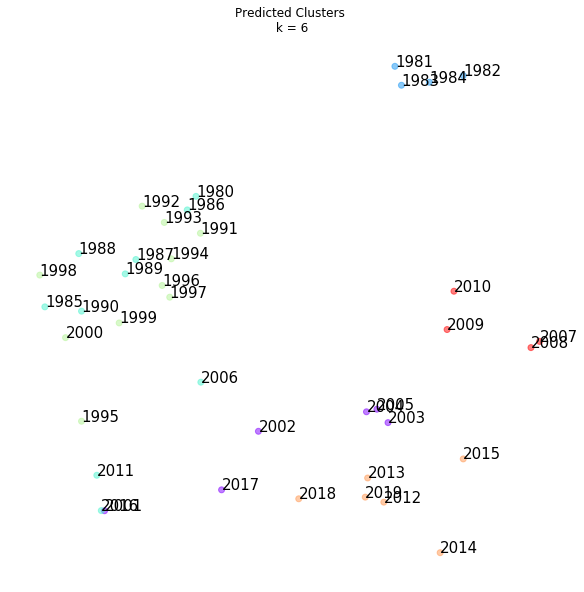

In [27]:
numCategories = 6
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year, (reducedPCA_speechData[:, 0][i],reducedPCA_speechData[:, 1][i]),size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories))
plt.show()

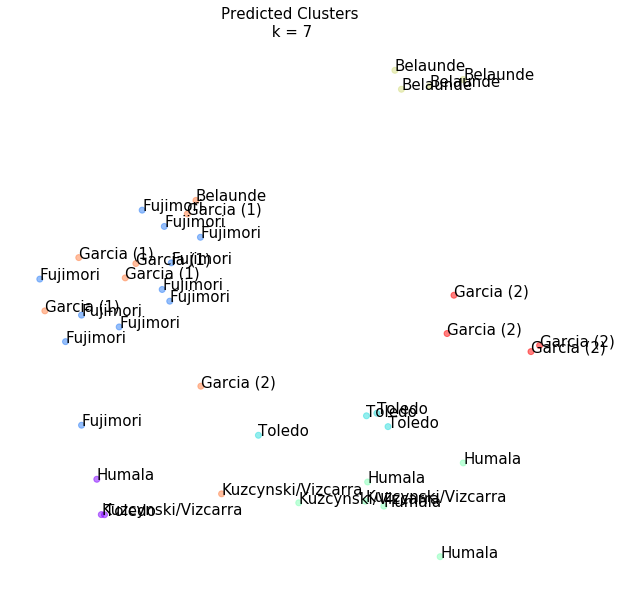

In [28]:
numCategories = 7
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['administration']):
    ax.annotate(year,
                (reducedPCA_speechData[:, 0][i],
                 reducedPCA_speechData[:, 1][i]),
                size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories), size=15)
plt.show()

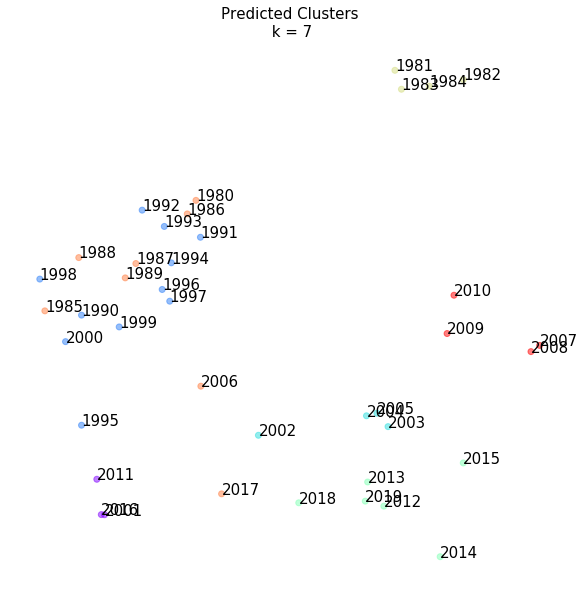

In [29]:
numCategories = 7
colors = list(plt.cm.rainbow(np.linspace(0,1, numCategories)))
colors_p = [colors[l] for l in targetDF['kmeans' + str(numCategories)]]

# Plotting
plt.figure(figsize=(10,10))
fig = plt.figure(1)
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reducedPCA_speechData[:, 0], reducedPCA_speechData[:, 1], color = colors_p, alpha = 0.5)
plt.xticks(())
plt.yticks(())
for i, year in enumerate(speech['year']):
    ax.annotate(year,
                (reducedPCA_speechData[:, 0][i],
                 reducedPCA_speechData[:, 1][i]),
                size=15)
plt.title('Predicted Clusters\n k = {}'.format(numCategories), size=15)
plt.show()

### Top terms per cluster

In [30]:
km = sklearn.cluster.KMeans(n_clusters=numCategories, init='k-means++')

In [31]:
terms = speechTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = speechKM.cluster_centers_.argsort()[:, ::-1]
for i in range(numCategories):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 un
 una
 no
 es
 todos
 perú
 más
 nuestra
 mi
 hoy


Cluster 1:
 un
 no
 una
 es
 ha
 más
 perú
 gobierno
 esta
 estado


Cluster 2:
 un
 es
 no
 mil
 una
 ha
 más
 gobierno
 millones
 nacional


Cluster 3:
 un
 una
 más
 es
 mil
 hemos
 millones
 ha
 no
 gobierno


Cluster 4:
 ha
 un
 una
 no
 han
 más
 nacional
 es
 000
 gobierno


Cluster 5:
 un
 es
 no
 una
 más
 pero
 ha
 perú
 estado
 nos


Cluster 6:
 mil
 millones
 un
 más
 ha
 es
 pero
 no
 una
 han




### Optimal cluster number

In [32]:
def plotSilhouette2(n_clusters, X, reduced_data, pca):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


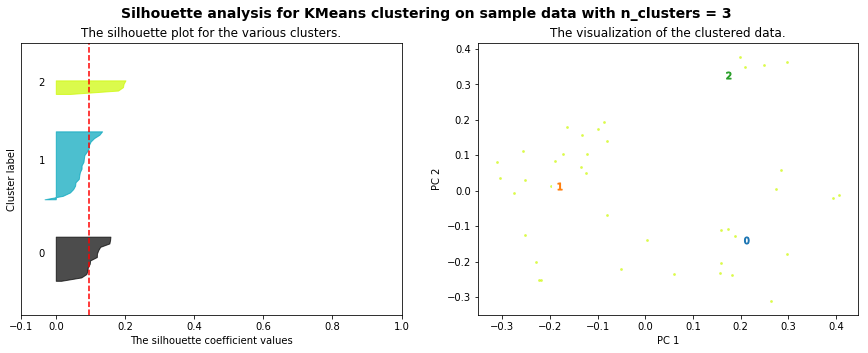

For n_clusters = 3, The average silhouette_score is : 0.097


In [33]:
X = speechTFVects.toarray()
plotSilhouette2(3, X, reducedPCA_speechData, speechPCA)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


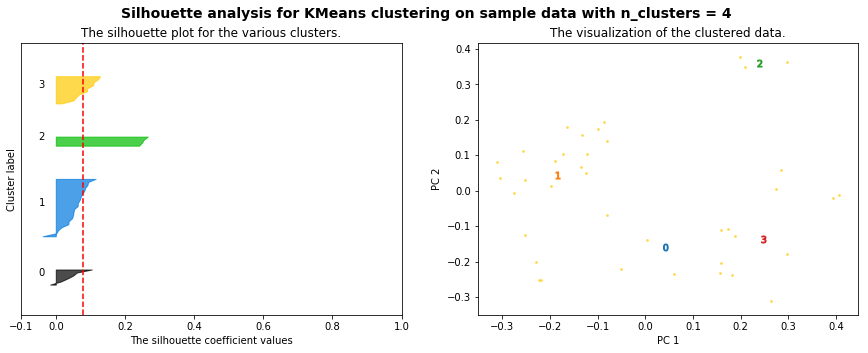

For n_clusters = 4, The average silhouette_score is : 0.079


In [34]:
X = speechTFVects.toarray()
plotSilhouette2(4, X, reducedPCA_speechData, speechPCA)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


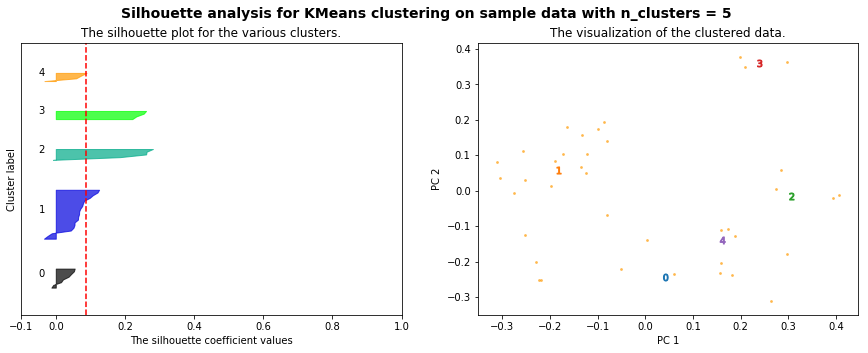

For n_clusters = 5, The average silhouette_score is : 0.087


In [35]:
X = speechTFVects.toarray()
plotSilhouette2(5, X, reducedPCA_speechData, speechPCA)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


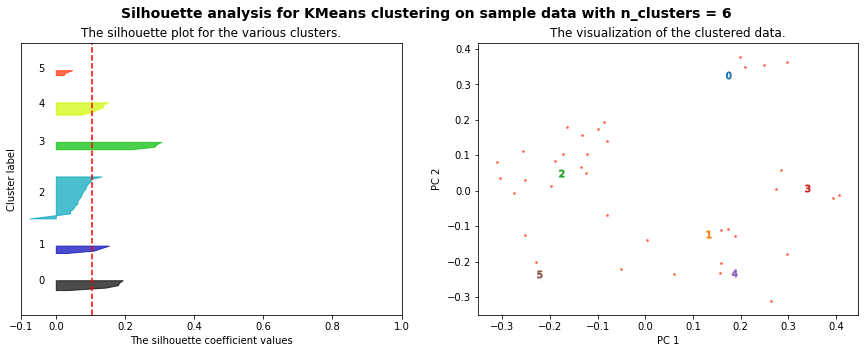

For n_clusters = 6, The average silhouette_score is : 0.105


In [36]:
X = speechTFVects.toarray()
plotSilhouette2(6, X, reducedPCA_speechData, speechPCA)

This is the optimal ^

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


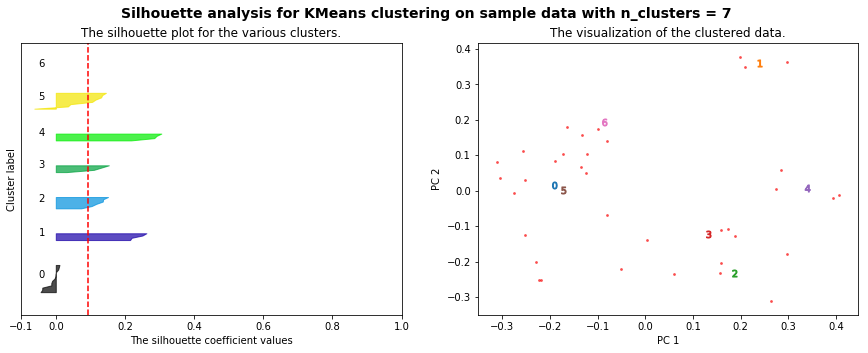

For n_clusters = 7, The average silhouette_score is : 0.092


In [37]:
X = speechTFVects.toarray()
plotSilhouette2(7, X, reducedPCA_speechData, speechPCA)

# Hierarchical Clustering with Wald's Method

Next we approach a hierchical clustering method, which proposes nested clusters at any resolution (at the finest resolution, every document is its own cluster).

Here we must begin by calculating how similar the documents are to one another.

As a first pass, we take our matrix of word counts per document
`newsgroupsTFVects` and create a word occurrence matrix measuring how similar
the documents are to each other based on their number of shared words. (Note one could perform the converse operation, a document occurrence matrix measuring how similar  words are to each other based on their number of collocated documents).

In [ ]:
newsgroupsTFVects

In [ ]:
newsgroupsTFVects[:100].todense()

In [ ]:
newsgroupsCoocMat = newsgroupsTFVects * newsgroupsTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
newsgroupsCoocMat.setdiag(0)
#Another way of relating the texts is with their cosine similarity
#newsgroupsCosinMat1 = 1 - sklearn.metrics.pairwise.cosine_similarity(newsgroupsTFVects)
#But generally word occurrence is more accurate


Now we can compute a tree of nested clusters. Here we will only look at the first 50 texts of each class because drawing the dendrograms can be computationally intensive (and visually complex).

In [ ]:
selectIndices = []
indexToCat = []
for c in set(newsgroupsDF['category']):
    selectIndices += list(newsgroupsDF[newsgroupsDF['category'] == c].index)[:50]
    indexToCat += [c] * 50
    #.groupby('category').sum()

In [ ]:
subCoocMat = newsgroupsCoocMat[selectIndices,:][:,selectIndices]

In [ ]:
linkage_matrix = scipy.cluster.hierarchy.ward(subCoocMat.toarray())
linkage_matrix[:10]

Now we can visualize the tree

In [ ]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This plot may seem somewhat unwieldy. To make it easier to read, we can cut the tree after a number of branchings.

In [ ]:
dendrogramDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)

By default, the tree is colored to show the clusters based on their ['distance'](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html#scipy.cluster.hierarchy.dendrogram) from one another, but there are other ways of forming hierarchical clusters.

Another approach involves cutting the tree into `n` branches. We can do this with [`fcluster()`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.cluster.hierarchy.fcluster.html#scipy.cluster.hierarchy.fcluster). Lets break the tree into 4 clusters. When we do this with all of the data in the dataframe, as below, we can add those clusters back for detailed evaluation.

In [ ]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters

We can use this *get clusters* like we did with k-means. What if we do the full data set?

In [ ]:
linkage_matrix_full = scipy.cluster.hierarchy.ward(newsgroupsCoocMat.toarray())
hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(linkage_matrix_full, 4, 'maxclust')
print("For our complete clusters:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(newsgroupsDF['category'], hierarchicalClusters_full)))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(newsgroupsDF['category'], hierarchicalClusters_full)))

Not quite as good as k-means. Perhaps we've got too many words for Ward or maybe we shouldn't be using TFIDF as that compresses the space. Still, the hierarchical model places constraints on the clustering not present with k-means, which come at a cost. Finally, we can bring those cluster assignments back to the data frame for deeper investigation.

In [ ]:
newsgroupsDF['wald_predictions'] = hierarchicalClusters_full
newsgroupsDF

# Now let's do it with Senate press release data

We can also do hierarchical clustering with the Senate data. Let's start by creating the linkage matrix:

In [ ]:
exampleCoocMat = exampleTFVects * exampleTFVects.T
exampleCoocMat.setdiag(0)
examplelinkage_matrix = scipy.cluster.hierarchy.ward(exampleCoocMat[:100, :100].toarray())

And visualize the tree:

In [ ]:
ax = scipy.cluster.hierarchy.dendrogram(examplelinkage_matrix, p=5, truncate_mode='level')

Now let's do it with the entire data frame.

In [ ]:
example_linkage_matrix_full = scipy.cluster.hierarchy.ward(exampleCoocMat.toarray())
example_hierarchicalClusters_full = scipy.cluster.hierarchy.fcluster(example_linkage_matrix_full, 4, 'maxclust')

In [ ]:
ax = scipy.cluster.hierarchy.dendrogram(example_linkage_matrix_full, p=5, truncate_mode='level')

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

In [41]:
speechTFVects.shape

(40, 5342)

In [42]:
speechCoocMat = speechTFVects * speechTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
speechCoocMat.setdiag(0)

In [43]:
linkage_matrix = scipy.cluster.hierarchy.ward(speechCoocMat.toarray())

/home/lsanmartin/.local/lib/python3.5/site-packages/scipy/cluster/hierarchy.py:482: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


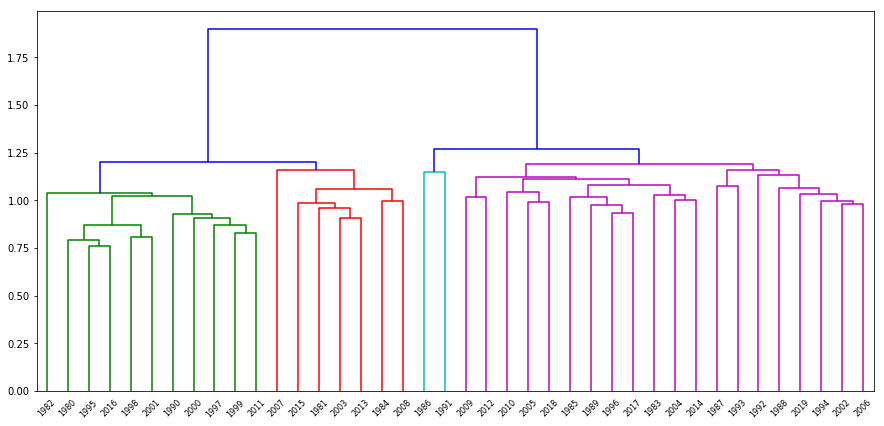

In [44]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),
                                             color_threshold=1.2)

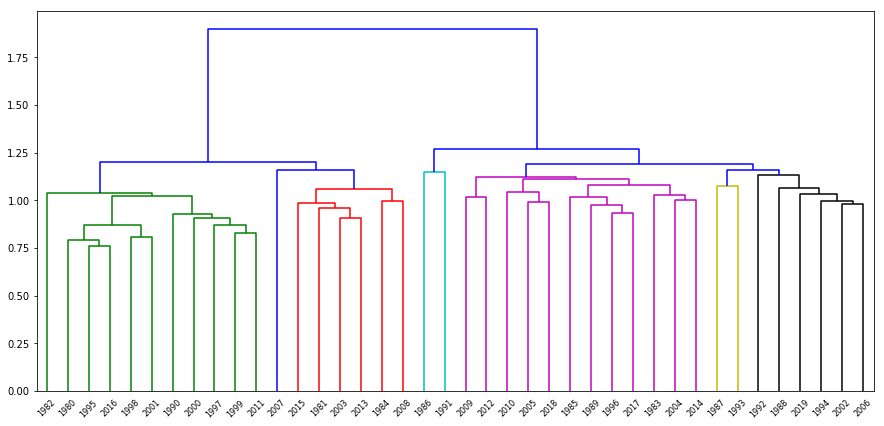

In [57]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['year']),
                                             color_threshold=1.15)

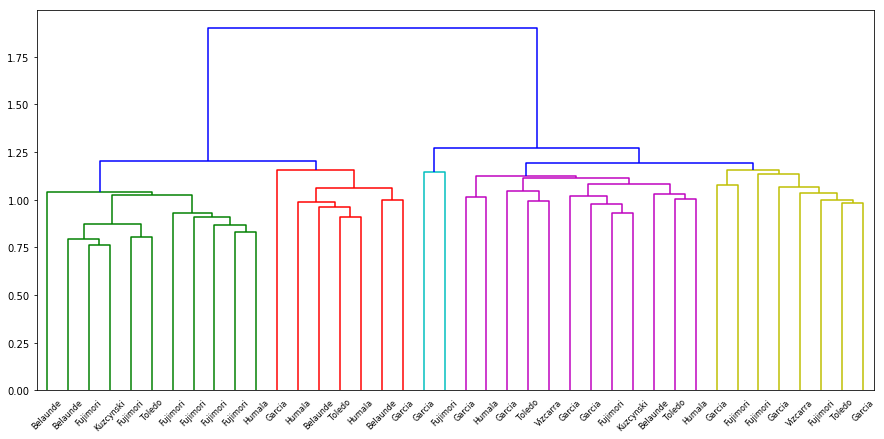

In [45]:
plt.figure(figsize=(15,7))
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix,
                                             get_leaves=True,
                                             labels=list(speech['president']),
                                             color_threshold=1.183)

In [46]:
speech['wald7'] = scipy.cluster.hierarchy.fcluster(linkage_matrix, 7, 'maxclust')

In [58]:
print("Wald - 7 groups:")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speech['president'], speech['wald7'])))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speech['president'], speech['wald7'])))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speech['president'], speech['wald7'])))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speech['president'], speech['wald7'])))

Wald - 7 groups:
Homogeneity: 0.235
Completeness: 0.250
V-measure: 0.242
Adjusted Rand Score: 0.018


In [59]:
print("K-means (k=7):")
print("Homogeneity: {:0.3f}".format(sklearn.metrics.homogeneity_score(speech['president'], speech['kmeans7'])))
print("Completeness: {:0.3f}".format(sklearn.metrics.completeness_score(speech['president'], speech['kmeans7'])))
print("V-measure: {:0.3f}".format(sklearn.metrics.v_measure_score(speech['president'], speech['kmeans7'])))
print("Adjusted Rand Score: {:0.3f}".format(sklearn.metrics.adjusted_rand_score(speech['president'], speech['kmeans7'])))

K-means (k=7):
Homogeneity: 0.764
Completeness: 0.737
V-measure: 0.750
Adjusted Rand Score: 0.627


# Gensim

To do topic modeling we will also be using data from the [grimmer press releases corpus](ttps://github.com/lintool/GrimmerSenatePressReleases). To use the texts with gensim we need to create a `corpua` object, this takes a few steps. First we create a `Dictionary` that maps tokens to ids.

In [ ]:
#Apply our functions
senReleasesTraining['tokenized_text'] = senReleasesTraining['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
senReleasesTraining['normalized_tokens'] = senReleasesTraining['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

In [ ]:
senReleasesTraining[::100]

In [44]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

In [ ]:
senReleasesTraining['reduced_tokens'] = senReleasesTraining['normalized_tokens'].apply(lambda x: dropMissing(x, senTFVectorizer.vocabulary_.keys()))

In [ ]:
dictionary = gensim.corpora.Dictionary(senReleasesTraining['reduced_tokens'])

Then for each of the texts we create a list of tuples containing each token and its count. We will only use the first half of our dataset for now and will save the remainder for testing.

In [ ]:
corpus = [dictionary.doc2bow(text) for text in senReleasesTraining['reduced_tokens']]

Then we serialize the corpus as a file and load it. This is an important step when the corpus is large.

In [ ]:
gensim.corpora.MmCorpus.serialize('senate.mm', corpus)
senmm = gensim.corpora.MmCorpus('senate.mm')

Now we have a correctly formatted corpus that we can use for topic modeling and induction.

In [ ]:
senlda = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

We can inspect the degree to which distinct texts load on different topics. Here is one of the texts from the training set:

In [ ]:
sen1Bow = dictionary.doc2bow(senReleasesTraining['reduced_tokens'][0])
sen1lda = senlda[sen1Bow]
print("The topics of the text: {}".format(senReleasesTraining['name'][0]))
print("are: {}".format(sen1lda))

We can now see which topics our model predicts press releases load on and make this into a `dataFrame` for later analysis.

In [ ]:
ldaDF = pandas.DataFrame({
        'name' : senReleasesTraining['name'],
        'topics' : [senlda[dictionary.doc2bow(l)] for l in senReleasesTraining['reduced_tokens']]
    })

This is a bit unwieldy so lets make each topic its own column:

In [ ]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(senlda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(senlda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

Now let's visualize this for several (e.g., 10) documents in the corpus. First we'll subset the data:

In [ ]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(10)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.as_matrix(columns=None)
ldaDFVisNames = ldaDFVisN.as_matrix(columns=None)
ldaDFV

First we can visualize as a stacked bar chart:

In [ ]:
N = 10
ind = np.arange(N)
K = senlda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Press Releases')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can also visualize as a heat map:

In [ ]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

We can also look at the top words from each topic to get a sense of the semantic (or syntactic) domain they represent. To look at the terms with the highest LDA weight in topic `1` we can do the following:

In [ ]:
senlda.show_topic(1)

And if we want to make a dataFrame:

In [ ]:
topicsDict = {}
for topicNum in range(senlda.num_topics):
    topicWords = [w for w, p in senlda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

We can see that several of the topics have the same top words, but there are definitely differences. We can try and make the topics more distinct by changing the $\alpha$ and $\eta$ parameters of the model. $\alpha$ controls the sparsity of document-topic loadings, and $\eta$ controls the sparsity of topic-word loadings.

We can make a visualization of the distribution of words over any single topic.

In [ ]:
topic1_df = pandas.DataFrame(senlda.show_topic(1, topn=50))
plt.figure()
topic1_df.plot.bar(legend = False)
plt.title('Probability Distribution of Words, Topic 1')
plt.show()

See how different $\eta$ values can change the shape of the distribution.

In [ ]:
senlda1 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.00001)
senlda2 = gensim.models.ldamodel.LdaModel(corpus=senmm, id2word=dictionary, num_topics=10, eta = 0.9)

In [ ]:
topic11_df = pandas.DataFrame(senlda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(senlda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

In [38]:
speech['tokenized_text'] = speech['cleaned text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))

In [39]:
import spacy

In [40]:
nlp = spacy.load("es")

In [41]:
def normalizeTokens(word_list, extra_stop=[]):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            normalized.append(str(w.lemma_))

    return normalized

In [42]:
speech['normalized_tokens'] = speech['tokenized_text'].apply(lambda x: normalizeTokens(x, stop_words))

In [45]:
speech['reduced_tokens'] = speech['normalized_tokens'].apply(lambda x: dropMissing(x, speechTFVectorizer.vocabulary_.keys()))

In [46]:
dictionary_speech = gensim.corpora.Dictionary(speech['reduced_tokens'])

In [47]:
corpus_speech = [dictionary_speech.doc2bow(text) for text in speech['reduced_tokens']]

In [48]:
gensim.corpora.MmCorpus.serialize('speech_peru.mm', corpus_speech)

In [49]:
n_topics = 7
speech_lda = gensim.models.ldamodel.LdaModel(corpus=corpus_speech,
                                             id2word=dictionary_speech,
                                             num_topics=n_topics,
                                             alpha='auto',
                                             eta='auto',
                                             #alpha=0.99,
                                             #eta=0.99
                                            )

In [92]:
speech_ldaDF = pandas.DataFrame({
        'year' : speech['year'],
        'president': speech['president'],
        'year-president': speech['year-president'],
        'topics' : [speech_lda[dictionary_speech.doc2bow(l)] for l in speech['reduced_tokens']]
    })

In [94]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(speech_ldaDF) for i in range(speech_lda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(speech_ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(speech_lda.num_topics):
    speech_ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [52]:
speechDFV = speech_ldaDF[['topic_%d' %x for x in range(n_topics)]]
speechDFVisN = speech_ldaDF[['year-president']]
speechDFVis = speechDFV.as_matrix(columns=None)
speechDFVisNames = speechDFVisN.as_matrix(columns=None)
topic_labels = ['Topic #{}'.format(k) for k in range(n_topics)]

In [53]:
topicsDict = {}
for topicNum in range(speech_lda.num_topics):
    topicWords = [w for w, p in speech_lda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3,Topic_4,Topic_5,Topic_6
0,gobernar,millón,gobernar,perú,nacional,millón,millón
1,millón,perú,nacional,gobernar,millón,perú,perú
2,nacional,gobernar,perú,nacional,perú,gobernar,gobernar
3,perú,nacional,millón,social,gobernar,peruano,nacional
4,peruano,peruano,peruano,inversión,peruano,nacional,social
5,político,social,desarrollar,político,desarrollar,político,peruano
6,inversión,desarrollar,político,permitir,político,sector,inversión
7,salud,ley,inversión,peruano,ley,público,desarrollar
8,deber,político,social,económico,social,económico,deber
9,social,dólar,ley,millón,permitir,desarrollar,público


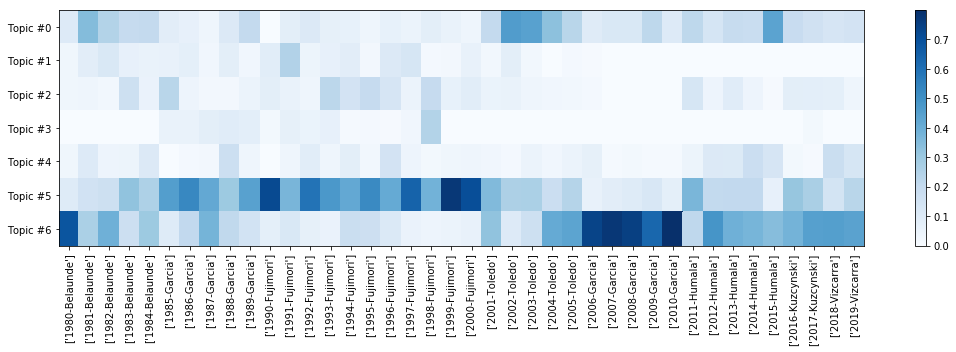

In [54]:
plt.figure(figsize = (15,5))
plt.pcolor(speechDFVis.T, norm=None, cmap='Blues')
plt.xticks(np.arange(speechDFVis.shape[0])+0.5, speechDFVisNames);
plt.yticks(np.arange(speechDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [55]:
ymin = 0
ymax = 0.02

<Figure size 432x288 with 0 Axes>

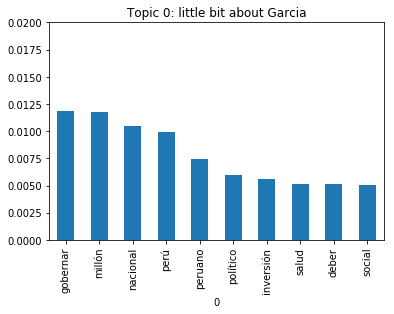

In [56]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(0, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 0: little bit about Garcia')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

<Figure size 432x288 with 0 Axes>

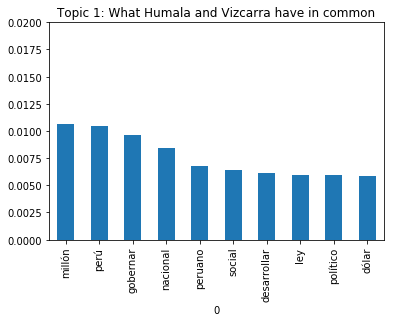

In [57]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(1, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 1: What Humala and Vizcarra have in common')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

<Figure size 432x288 with 0 Axes>

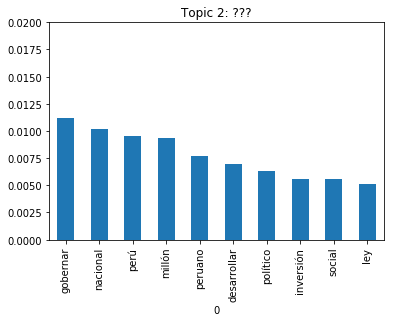

In [58]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(2, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 2: ???')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

<Figure size 432x288 with 0 Axes>

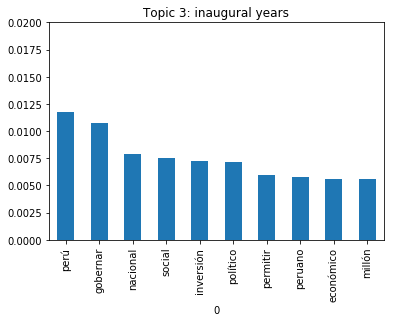

In [59]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(3, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 3: inaugural years')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

<Figure size 432x288 with 0 Axes>

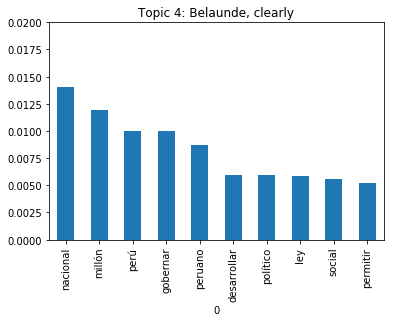

In [60]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(4, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 4: Belaunde, clearly')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

<Figure size 432x288 with 0 Axes>

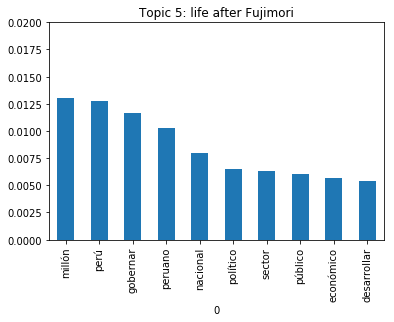

In [61]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(5, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 5: life after Fujimori')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

<Figure size 432x288 with 0 Axes>

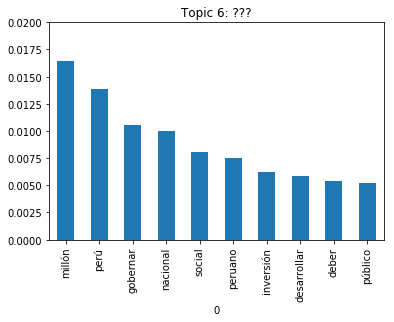

In [62]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(6, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 6: ???')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

## Extending Topic Models within broader research pipelines

Topic models can be the base of more complex analysis. One good example is the paper - Individuals, institutions, and innovation in the debates of the French Revolution (https://www.pnas.org/content/115/18/4607), where they use topic models to find similarities and differences between the topics of different individuals. Let us revisit this idea using the Soap opera database. Who innovates and influences the most within the Soap?

The next few lines of code follows the same process as last weeks notebook. Please visit the old notebook to read descriptions of the code if you have forgotten what it does.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/SOAP"

In [ ]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

In [ ]:
import zipfile
import pandas as pd

In [ ]:
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []

In [ ]:
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

In [ ]:
soap_dict = {}

In [ ]:
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [ ]:
soap_dict.keys()

In [ ]:
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])

In [ ]:
i = 0

In [ ]:
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1

In [ ]:
soap_df

Checking to see which index I should use. In my example it is the first one, so I choose my index as 0. It might be different for you!

In [ ]:
dool = soap_df['Tokenized Texts'][0]

In [ ]:
' '.join(dool[0:1500])

In [ ]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1

In [ ]:
import networkx as nx

In [ ]:
actor_network = nx.Graph()

In [ ]:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])

In [ ]:
i = 0

In [ ]:
all_texts = []

In [ ]:
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])
            all_texts.append(lucem_illud_2020.normalizeTokens(dool[i:j]))

In [ ]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Ok - so we have our graph now. Let us create a topic model with all the texts spoken by the characters, see what's being spoken about, and construct topic distributions for each character. What does our all_texts corpus look like?

In [ ]:
all_texts[0:10]

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('dool.mm', corpus)
doolcorpus = gensim.corpora.MmCorpus('dool.mm')

In [ ]:
doollda = gensim.models.ldamodel.LdaModel(corpus=doolcorpus, id2word=dictionary, num_topics=10, alpha='auto', eta='auto')

In [ ]:
doollda.show_topics()

Are your topics interpretable/interesting? Sometimes they require a good deal of fine tuning and parameter choosing to get it to work in a nice way. Check out the gensim ldamodel documentation page and see what parameters you can play around with and try the model again!

In [ ]:
for actor in actor_network.nodes():
    actor_all_words = []
    for sent in actor_network.nodes[actor]['words']:
        for word in sent:
            actor_all_words += word
    actor_network.nodes[actor]['topic_distribution'] = doollda[dictionary.doc2bow(lucem_illud_2020.normalizeTokens(actor_all_words))]

We now have topic distributions for each character. Let us have a brief look at what the characters are talking about. 

In [ ]:
for actor in actor_network.nodes():
    print(actor_network.nodes[actor]['topic_distribution'])

Quickly eye-balling these distributions suggest that the model itself could be tuned better - all the topics are loaded more or less equally. 

In the paper I linked to earlier, they found similarities or differences using the KL divergence - this is a topic we've dealt with before. Let us plot a heatmap with these values.

In [ ]:
from gensim.matutils import kullback_leibler

In [ ]:
def convert_to_prob(bow):
    ps = []
    for topic_no, topic_prob in bow:
        ps.append(topic_prob)
    return ps

In [ ]:
L = []
for actor_1 in actor_network.nodes():
    p = actor_network.nodes[actor_1]['topic_distribution'] 
    p = convert_to_prob(p)
    l = []
    for actor_2 in actor_network.nodes():
        q = actor_network.nodes[actor_2]['topic_distribution'] 
        q = convert_to_prob(q)
        l.append(kullback_leibler(p, q))
    L.append(l)
M = np.array(L)

In [ ]:
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

This is one example of how we can use topic models to analyse a network - what other data exploration can you come up with?  Maybe see what are the themes surrounding the top topics for each of the actors? You now have the infrastructure to explore the network and the topics. Gensim has a great set of Jupyter Notebooks which illustrate their methods and functions - https://github.com/RaRe-Technologies/gensim/tree/develop/docs/notebooks. The Auto Examples page also has a good variety of examples - https://radimrehurek.com/gensim/auto_examples/. 


### Dynamic Topic Modelling

Dynamic Topic Modelling is a time based topic model method introduced by David Blei and John Lafferty. It allows one to see topics evolve over a time annotated corpus. I would recommend first viewing the Dynamic Topic Model tutorial on Gensim (https://github.com/RaRe-Technologies/gensim/blob/develop/docs/notebooks/ldaseqmodel.ipynb) to understand what exactly it's about. 

(An acknowledgement - Bhargav wrote the code for Gensim's Dynamic Topic Models back in 2016 as a Google Summer of Code student, and they're still using it as are thousands of others!)

To demonstrate it on a time based corpus, we will create a corpus from COHA.

In [ ]:
corpora_address = "/Users/bhargavvader/Downloads/Academics_Tech/corpora/COHA"

In [ ]:
coha_texts = lucem_illud_2020.loadDavies(corpora_address, return_raw=True)

In [ ]:
list(coha_texts.keys())[0:5]

We'd have to approach this differently: note that while extracting the corpus we returned the raw texts (a new functionality in lucem_illud_2020), and the dictionary keys already contain some useful information: the year published, and the genre. neat! We can now create some corpora, organised by year and by genre.

In [ ]:
coha_genres = {}
coha_years = {}

In [ ]:
for article in coha_texts:
    genre, year, id_ = article.split("_")
    if genre not in coha_genres:
        coha_genres[genre] = []
    if genre in coha_genres:
        coha_genres[genre].append(coha_texts[article])
    
    if year not in coha_years:
        coha_years[year] = []
    if year in coha_years:
        coha_years[year].append(coha_texts[article])
    

In [ ]:
coha_genres.keys()

In [ ]:
coha_years.keys()

That's neat: we have 4 genres and 200 years. We have to now decide how many time slices we want. Let us see how the corpus is distributed.

If you went through the tutorial, you would notice how we would need to arrange the corpora year wise.
We also have to arrange the number of topics per year.

In [ ]:
import collections

In [ ]:
years = []
year_lens = []

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    years.append(year_info)
    year_lens.append(len((coha_years[year_info])))

In [ ]:
years[0], years[-1]

In [ ]:
import matplotlib.pyplot as plt
plt.plot(years, year_lens)

The X axis isn't legible, but you can get the point: their are far less articles in the beginning, and then it grows. Maybe in our 4 time slices, we do: 1810-1880, 1881-1913, 1914-1950, 1950-1990, 1990-2009?
I use some historical intuition to use these time periods, you are encouraged to try your different time slices (for e.g, 20 10 year periods, 10 20 year periods, by total number of papers, etc)

In [ ]:
all_texts = []
docs_per_year = [0, 0, 0, 0, 0]
i = 0

In [ ]:
for year_info in collections.OrderedDict(sorted(coha_years.items())):
    large_files = 0
    for article in coha_years[year_info]:
        if len(article[2]) < 1500000:
            all_texts.append(lucem_illud_2020.normalizeTokens(article[2].decode("utf-8")))
        if len(article[2]) >= 1500000:
            large_files += 1
    if i < 70:
        docs_per_year[0] += len(coha_years[year_info]) - large_files
    if i >= 70 and i < 103:
        docs_per_year[1] += len(coha_years[year_info]) - large_files
    if i >= 103 and i < 140:
        docs_per_year[2] += len(coha_years[year_info]) - large_files
    if i >= 140 and i < 180:
        docs_per_year[3] += len(coha_years[year_info]) - large_files
    if i >= 180:
        docs_per_year[4] += len(coha_years[year_info]) - large_files
    i += 1

In [ ]:
dictionary = gensim.corpora.Dictionary(all_texts)

In [ ]:
corpus = [dictionary.doc2bow(text) for text in all_texts]

In [ ]:
gensim.corpora.MmCorpus.serialize('coha.mm', corpus)
cohacorpus = gensim.corpora.MmCorpus('coha.mm')

#### Smaller Corpora

The original size of the corpus is wayyy too big for our laptops. Let us demo this with a smaller size.

In [ ]:
def choose_n(corpus, time_slices, nums=1000):
    new_corpus = corpus[0:nums]
    for time_slice in time_slices[:-1]:
        new_corpus = new_corpus + corpus[time_slice:time_slice+nums]
    return new_corpus

In [ ]:
small_corpus = choose_n(corpus, docs_per_year, nums=10)

In [ ]:
small_docs = [10, 10, 10, 10, 10]

In [65]:
from gensim.models import ldaseqmodel

In [ ]:
# ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_year, num_topics=4)

In [ ]:
 ldaseq = ldaseqmodel.LdaSeqModel(corpus=small_corpus, id2word=dictionary, time_slice=small_docs, num_topics=4)

In [ ]:
ldaseq.print_topics(time=0)

In [ ]:
ldaseq.print_topics(time=1)

What can you see from the analysis? I encourage you to explore the tutorial and see what else you can do with this dataset. 

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

In [66]:
time_slice_speech = [5, 5, 11, 5, 5, 5, 4]

In [83]:
n_topics = 7

In [67]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus_speech,
                                 id2word=dictionary_speech,
                                 time_slice=time_slice_speech,
                                 num_topics=n_topics)

/home/lsanmartin/.local/lib/python3.5/site-packages/gensim/models/ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [82]:
ldaseqDF = pandas.DataFrame({
        'name' : speech['year-president'],
        'topics' : [ldaseq[dictionary_speech.doc2bow(l)] for l in speech['reduced_tokens']]
    })

In [97]:
ldaseqDF['topics'][0]

array([0.05927063, 0.04709559, 0.01087711, 0.07765884, 0.02822849,
       0.73917537, 0.03769398])

In [98]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaseqDF) for i in range(ldaseq.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaseqDF['topics']):
    for topicNum, prob in enumerate(topicTuples):
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(ldaseq.num_topics):
    ldaseqDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

In [122]:
ldaseqDFV = ldaseqDF[['topic_%d' %x for x in range(n_topics)]]
ldaseqDFVisN = ldaseqDF[['name']]
ldaseqDFVis = ldaseqDF.as_matrix(columns=['topic_0',
                                          'topic_1',
                                          'topic_2',
                                          'topic_3',
                                          'topic_4',
                                          'topic_5',
                                          'topic_6'])
#ldaseqDFVisNames = ldaseqDFVis.as_matrix(columns=None)
ldaseqDFVisNames = speech['year-president']

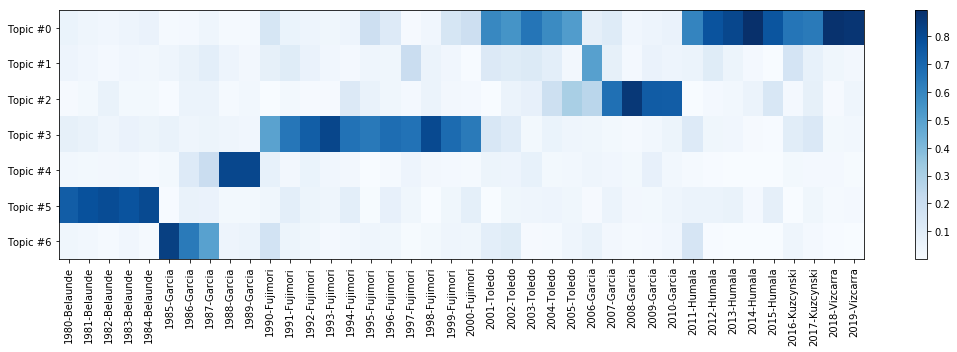

In [127]:
plt.figure(figsize = (15,5))
plt.pcolor(ldaseqDFVis.T, norm=None, cmap='Blues')
plt.xticks(np.arange(ldaseqDFVis.shape[0])+0.5, ldaseqDFVisNames);
plt.yticks(np.arange(ldaseqDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

In [55]:
ymin = 0
ymax = 0.02

In [158]:
df = pandas.DataFrame()
for i in [5, 3, 0, 2]:
    df['topic' + str(i)] = np.array(ldaseq.print_topic(i)[:10])[:,0]

In [159]:
df

,topic5,topic3,topic0,topic2
0,nacional,perú,gobernar,millón
1,desarrollar,gobernar,nacional,perú
2,gobernar,peruano,peruano,sol
3,servicio,nacional,perú,gobernar
4,construcción,empresa,político,entregar
5,sector,desarrollar,millón,inversión
6,público,sector,público,crecer
7,millón,dólar,desarrollar,aumentar
8,importante,millón,sol,avanzar
9,perú,político,ley,señor


In [151]:
np.array(ldaseq.print_topic(0)[:5])[:,0]

array(['gobernar', 'nacional', 'peruano', 'perú', 'político'],
      dtype='<U20')

In [148]:
a = ldaseq.print_topic(5)

In [146]:
ldaseq.print_topic(3)

[('perú', 0.01649297487261713),
 ('gobernar', 0.012762442750930136),
 ('peruano', 0.008684555140455835),
 ('nacional', 0.008301690359141623),
 ('empresa', 0.007717349687433525),
 ('desarrollar', 0.007265318114781834),
 ('sector', 0.007163085174064997),
 ('dólar', 0.0068210407660155665),
 ('millón', 0.005998840821362234),
 ('político', 0.005563116106233858),
 ('económico', 0.005061210711918285),
 ('procesar', 0.004721560466089931),
 ('internacional', 0.004512707471813529),
 ('permitir', 0.004427823970390705),
 ('economía', 0.0039645469441875495),
 ('público', 0.00384937153802031),
 ('poder', 0.0036467051580301325),
 ('derecho', 0.003558588687114157),
 ('inversión', 0.003517019743521067),
 ('lograr', 0.003252964273818502)]

In [147]:
ldaseq.print_topic(0)

[('gobernar', 0.015334325403424299),
 ('nacional', 0.014081484839528279),
 ('peruano', 0.011902697970460221),
 ('perú', 0.011379921145826815),
 ('político', 0.010612111023939797),
 ('millón', 0.008227236544321146),
 ('público', 0.0066859564358010505),
 ('desarrollar', 0.006535069896661483),
 ('sol', 0.006506490088034859),
 ('ley', 0.006491978434863826),
 ('social', 0.006108555714812153),
 ('inversión', 0.005971480020538849),
 ('congreso', 0.005515781634903779),
 ('mejorar', 0.005322664985377594),
 ('presidente', 0.005258627125561688),
 ('salud', 0.005198821637403207),
 ('crecimiento', 0.005126985583498844),
 ('reformar', 0.00502160394194577),
 ('permitir', 0.004993740956372685),
 ('niño', 0.004752699798792108)]

In [132]:
dir(ldaseq)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_adapt_by_suffix',
 '_load_specials',
 '_save_specials',
 '_smart_save',
 'alphas',
 'corpus_len',
 'doc_topics',
 'dtm_coherence',
 'dtm_vis',
 'fit_lda_seq',
 'fit_lda_seq_topics',
 'gammas',
 'id2word',
 'inferDTMseq',
 'influence',
 'influence_sum_lgl',
 'init_ldaseq_ss',
 'lda_seq_infer',
 'load',
 'make_lda_seq_slice',
 'max_doc_len',
 'num_time_slices',
 'num_topics',
 'print_topic',
 'print_topic_times',
 'print_topics',
 'renormalized_influence',
 'save',
 'sstats',
 'time_slice',
 'top_doc_phis',
 'topic_chains',
 'vocab_len']

In [128]:
topic1_df = pandas.DataFrame(speech_lda.show_topic(0, topn=10))
plt.figure()
topic1_df.plot.bar(legend = False, x=0)
plt.title('Topic 0: little bit about Garcia')
axes = plt.gca()
axes.set_ylim([ymin,ymax])
plt.show()

AttributeError: 'LdaSeqModel' object has no attribute 'show_topic'